In [1]:
import os

# Dataset root path
data_dir = '/kaggle/input/a-large-publicly-available-electrocardiography/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3'

# List to store all file paths
all_files = []

# Walk through every folder and subfolder
for root, dirs, files in os.walk(data_dir):
    for f in files:
        file_path = os.path.join(root, f)
        all_files.append(file_path)

# Show total number of files
print(f"✅ Total files found: {len(all_files)}")

# Show a few sample file paths
print("\n📂 Example file paths:")
for i, path in enumerate(all_files[:15]):
    print(f"{i+1}. {path}")

# Optional: summary by folder (robust version)
folder_summary = {}
for f in all_files:
    relative_path = os.path.dirname(f).replace(data_dir, '').strip(os.sep)
    parts = relative_path.split(os.sep)
    folder = parts[0] if len(parts) > 0 and parts[0] != '' else "root"
    folder_summary[folder] = folder_summary.get(folder, 0) + 1

print("\n📊 File count by top-level folder:")
for k, v in folder_summary.items():
    print(f"{k:20s} : {v}")


✅ Total files found: 87204

📂 Example file paths:
1. /kaggle/input/a-large-publicly-available-electrocardiography/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/SHA256SUMS.txt
2. /kaggle/input/a-large-publicly-available-electrocardiography/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/RECORDS
3. /kaggle/input/a-large-publicly-available-electrocardiography/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/example_physionet.py
4. /kaggle/input/a-large-publicly-available-electrocardiography/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/ptbxl_v103_changelog.txt
5. /kaggle/input/a-large-publicly-available-electrocardiography/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/scp_statements.csv
6. /kaggle/input/a-large-publicly-available-electrocardiography/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/ptbxl_database.csv
7. /kaggle/input/a-large-publicly-available-electro

In [2]:
# === Step 0: Install required library ===
!pip install wfdb

# === Step 1: Import libraries ===
import os
import pandas as pd
import numpy as np
import wfdb
import ast

# === Step 2: Define ECG data loader ===
def load_raw_data(df, sampling_rate, path):
    """
    Load ECG signals from PTB-XL dataset.
    Returns a NumPy array of shape (n_samples, n_timesteps, n_leads)
    """
    file_col = 'filename_lr' if sampling_rate == 100 else 'filename_hr'
    data = [wfdb.rdsamp(os.path.join(path, f))[0] for f in df[file_col]]
    return np.array(data)

# === Step 3: Setup dataset path and sampling rate ===
path = '/kaggle/input/a-large-publicly-available-electrocardiography/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3'
sampling_rate = 100  # 100 Hz

# === Step 4: Load metadata and SCP codes ===
Y = pd.read_csv(os.path.join(path, 'ptbxl_database.csv'), index_col='ecg_id')
Y['scp_codes'] = Y['scp_codes'].apply(lambda x: ast.literal_eval(x))

# === Step 5: Load ECG signal data ===
print("Loading ECG signal data...")
X = load_raw_data(Y, sampling_rate, path)
print(f"✅ Loaded {len(X)} ECG samples.")

# === Step 6: Load SCP statements and keep only diagnostic ones ===
agg_df = pd.read_csv(os.path.join(path, 'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df['diagnostic'] == 1]  # keep only diagnostic statements

# === Step 7: Map SCP codes to diagnostic superclass ===
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

Y['diagnostic_superclass'] = Y['scp_codes'].apply(aggregate_diagnostic)

# === Step 8: Keep only single-label ECGs ===
mask = Y['diagnostic_superclass'].apply(lambda x: len(x) == 1)
Y_filtered = Y[mask].copy()
X_filtered = X[mask.values]  # align signals

# === Step 9: Convert label list to string ===
Y_filtered['diagnostic_superclass'] = Y_filtered['diagnostic_superclass'].apply(lambda x: x[0])

# === Step 10: Display summary ===
print(f"\n✅ Filtered samples: {len(X_filtered)}")
print("📊 Label distribution:\n")
print(Y_filtered['diagnostic_superclass'].value_counts())

# === Optional: save for reuse ===
# np.save('X_filtered.npy', X_filtered)
# Y_filtered.to_csv('Y_filtered.csv')



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 4.4 MB/s eta 0:00:0000:01
Loading ECG signal data...
✅ Loaded 21799 ECG samples.

✅ Filtered samples: 16244
📊 Label distribution:

diagnostic_superclass
NORM    9069
MI      2532
STTC    2400
CD      1708
HYP      535
Name: count, dtype: int64


In [3]:
from sklearn.model_selection import train_test_split
import pandas as pd

# === Step 1: Prepare data ===
X = X_filtered
y = Y_filtered['diagnostic_superclass']

# === Step 2: Split into train (60%) and temp (40%) ===
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,
    test_size=0.10,
    random_state=42,
    stratify=y
)

# === Step 3: Split train_val into train (≈80%) and val (≈10%) ===
# 0.1111 of 90% ≈ 10% total
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.1111,
    random_state=42,
    stratify=y_train_val
)

# === Step 4: Display summary ===
print("✅ Split Summary:")
print(f"Train: {len(X_train)} samples")
print(f"Validation: {len(X_val)} samples")
print(f"Test: {len(X_test)} samples")

print("\n📊 Label distribution:")
print("Train:\n", pd.Series(y_train).value_counts(), "\n")
print("Validation:\n", pd.Series(y_val).value_counts(), "\n")
print("Test:\n", pd.Series(y_test).value_counts())

print("\nShapes:")
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"X_test: {X_test.shape}")


✅ Split Summary:
Train: 12994 samples
Validation: 1625 samples
Test: 1625 samples

📊 Label distribution:
Train:
 diagnostic_superclass
NORM    7255
MI      2026
STTC    1920
CD      1366
HYP      427
Name: count, dtype: int64 

Validation:
 diagnostic_superclass
NORM    907
MI      253
STTC    240
CD      171
HYP      54
Name: count, dtype: int64 

Test:
 diagnostic_superclass
NORM    907
MI      253
STTC    240
CD      171
HYP      54
Name: count, dtype: int64

Shapes:
X_train: (12994, 1000, 12)
X_val: (1625, 1000, 12)
X_test: (1625, 1000, 12)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.1 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installe

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Data split: Train 60.00%, Val 10.00%, Test 30.00%
Model Params: 0.17M | GFLOPs per inference: 0.054
Epoch 1/50 | Train Loss: 0.8848 | Val Loss: 0.7644 | Val Acc: 70.69%
Epoch 2/50 | Train Loss: 0.6968 | Val Loss: 0.7958 | Val Acc: 68.53%
Epoch 3/50 | Train Loss: 0.6437 | Val Loss: 0.6639 | Val Acc: 76.29%
Epoch 4/50 | Train Loss: 0.6216 | Val Loss: 0.6780 | Val Acc: 74.75%
Epoch 5/50 | Train Loss: 0.5888 | Val Loss: 0.6126 | Val Acc: 78.39%
Epoch 6/50 | Train Loss: 0.5734 | Val Loss: 0.6277 | Val Acc: 78.39%
Epoch 7/50 | Train Loss: 0.5591 | Val Loss: 0.5413 | Val Acc: 80.54%
Epoch 8/50 | Train Loss: 0.5506 | Val Loss: 0.5669 | Val Acc: 79.93%
Epoch 9/50 | Train Loss: 0.5362 | Val Loss: 0.6361 | Val Acc: 76.79%
Epoch 10/50 | Train Loss: 0.5224 | Val Loss: 0.5887 | Val Acc: 79.50%
Epoch 11/50 | Train Loss: 0.5253 | Val Loss: 0.5465 | Val Acc: 81.16%
Epoch 12/50 | Train Loss: 0.5119 | Val Loss: 0.5487 | Val Acc: 80.60%
Epoch 13/50 | Train Loss: 0.5046 | Val Loss: 0.5256 | Val Acc: 81.34%

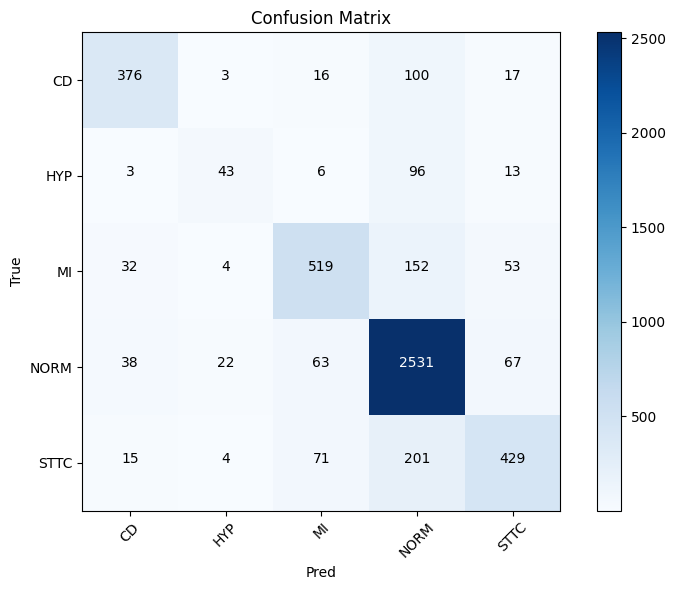

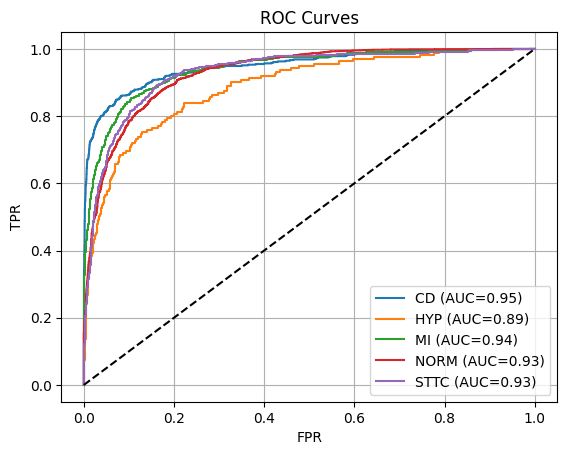

Model saved at ecgnet_outputs/ecgnet_60_10_30.pt
Training curves saved at ecgnet_outputs/training_epoch_stats.csv


In [4]:
# ==========================
# ECGNet: Full Training + Evaluation
# ==========================
!pip install ptflops --quiet

import os
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_fscore_support, roc_curve, auc, roc_auc_score
)

from ptflops import get_model_complexity_info

# ==========================
# 1️⃣ Data Preparation
# ==========================
# Assume X_filtered: (n_samples, seq_len, n_leads)
#       Y_filtered['diagnostic_superclass']: pd.Series

# 60% train, 10% val, 30% test split
X_train, X_temp, y_train, y_temp = train_test_split(
    X_filtered, Y_filtered['diagnostic_superclass'],
    test_size=0.40,
    random_state=42,
    stratify=Y_filtered['diagnostic_superclass']
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.75,
    random_state=42,
    stratify=y_temp
)

print(f"Data split: Train {len(X_train)/len(X_filtered):.2%}, "
      f"Val {len(X_val)/len(X_filtered):.2%}, "
      f"Test {len(X_test)/len(X_filtered):.2%}")

# Fix channel ordering for Conv1d: (batch, channels, seq_len)
X_train_cnn = np.transpose(np.array(X_train), (0,2,1))
X_val_cnn   = np.transpose(np.array(X_val), (0,2,1))
X_test_cnn  = np.transpose(np.array(X_test), (0,2,1))

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

# Convert to tensors
X_train_tensor = torch.tensor(X_train_cnn, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_enc, dtype=torch.long)
X_val_tensor   = torch.tensor(X_val_cnn, dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val_enc, dtype=torch.long)
X_test_tensor  = torch.tensor(X_test_cnn, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test_enc, dtype=torch.long)

# DataLoaders
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds   = TensorDataset(X_val_tensor, y_val_tensor)
test_ds  = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64)
test_loader  = DataLoader(test_ds, batch_size=64)

# ==========================
# 2️⃣ ECGNet Model
# ==========================
class ECGNet(nn.Module):
    def __init__(self, n_classes):
        super(ECGNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv1d(12, 32, kernel_size=7, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# ==========================
# 3️⃣ Model Setup
# ==========================
n_classes = len(le.classes_)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ECGNet(n_classes=n_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ==========================
# 4️⃣ GFLOPs Estimation
# ==========================
try:
    in_ch = X_train_tensor.shape[1]
    seq_len = X_train_tensor.shape[2]
    model_cpu = model.to('cpu')
    macs, params = get_model_complexity_info(model_cpu, (in_ch, seq_len), as_strings=False, print_per_layer_stat=False)
    gflops = (macs * 2) / 1e9
    print(f"Model Params: {params/1e6:.2f}M | GFLOPs per inference: {gflops:.3f}")
    model.to(device)
except Exception as e:
    print("GFLOPs estimation failed:", e)

# ==========================
# 5️⃣ Training Loop
# ==========================
EPOCHS = 50
train_losses, val_losses, val_accs = [], [], []

train_start_time = time.time()
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    correct, total = 0, 0
    val_loss = 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            logits = model(Xb)
            loss = criterion(logits, yb)
            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100.0 * correct / total
    val_losses.append(avg_val_loss)
    val_accs.append(val_accuracy)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")
train_end_time = time.time()
print(f"Training completed in {train_end_time - train_start_time:.2f} s")

# ==========================
# 6️⃣ Test Evaluation
# ==========================
model.eval()
all_preds, all_probs, all_labels = [], [], []
test_start_time = time.time()
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        logits = model(Xb)
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_probs.append(probs.cpu().numpy())
        all_labels.append(yb.numpy())
test_end_time = time.time()

y_true = np.concatenate(all_labels)
y_pred = np.concatenate(all_preds)
y_prob = np.concatenate(all_probs)
print(f"Test Accuracy: {(y_pred==y_true).mean()*100:.2f}%")
print(f"Test wall-clock: {test_end_time-test_start_time:.2f}s")

# ==========================
# 7️⃣ Metrics, Confusion Matrix, ROC–AUC
# ==========================
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix"); plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, le.classes_, rotation=45); plt.yticks(tick_marks, le.classes_)
thresh = cm.max()/2
for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i, format(cm[i,j],'d'), ha='center', color='white' if cm[i,j]>thresh else 'black')
plt.ylabel('True'); plt.xlabel('Pred'); plt.tight_layout(); plt.show()

# ROC–AUC curves
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{le.classes_[i]} (AUC={roc_auc[i]:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curves'); plt.legend(); plt.grid(True); plt.show()

# ==========================
# 8️⃣ Save Model & Outputs
# ==========================
out_dir = "ecgnet_outputs"
os.makedirs(out_dir, exist_ok=True)
torch.save(model.state_dict(), os.path.join(out_dir, "ecgnet_60_10_30.pt"))
print(f"Model saved at {os.path.join(out_dir, 'ecgnet_60_10_30.pt')}")

# Save training curves
df_epochs = pd.DataFrame({
    "epoch": np.arange(1,EPOCHS+1),
    "train_loss": train_losses,
    "val_loss": val_losses,
    "val_acc_pct": val_accs
})
df_epochs.to_csv(os.path.join(out_dir, "training_epoch_stats.csv"), index=False)
print(f"Training curves saved at {os.path.join(out_dir,'training_epoch_stats.csv')}")





✅ Data Split: Train 60.00%, Val 10.00%, Test 30.00%
✅ Model Params: 1.55M | GFLOPs per inference: 0.037
Epoch 1/50 | Train Loss: 1.2604 | Val Loss: 1.2107 | Val Acc: 56.90%
Epoch 2/50 | Train Loss: 1.1300 | Val Loss: 1.2110 | Val Acc: 55.54%
Epoch 3/50 | Train Loss: 0.9351 | Val Loss: 1.2522 | Val Acc: 54.56%
Epoch 4/50 | Train Loss: 0.6404 | Val Loss: 1.4347 | Val Acc: 54.43%
Epoch 5/50 | Train Loss: 0.3623 | Val Loss: 1.7205 | Val Acc: 49.82%
Epoch 6/50 | Train Loss: 0.1755 | Val Loss: 2.2245 | Val Acc: 51.23%
Epoch 7/50 | Train Loss: 0.0998 | Val Loss: 2.4987 | Val Acc: 51.85%
Epoch 8/50 | Train Loss: 0.0703 | Val Loss: 2.7015 | Val Acc: 54.19%
Epoch 9/50 | Train Loss: 0.0585 | Val Loss: 2.8648 | Val Acc: 52.59%
Epoch 10/50 | Train Loss: 0.0358 | Val Loss: 3.1302 | Val Acc: 52.46%
Epoch 11/50 | Train Loss: 0.0288 | Val Loss: 3.1632 | Val Acc: 52.09%
Epoch 12/50 | Train Loss: 0.0219 | Val Loss: 3.3078 | Val Acc: 51.11%
Epoch 13/50 | Train Loss: 0.0222 | Val Loss: 3.4980 | Val Acc: 53

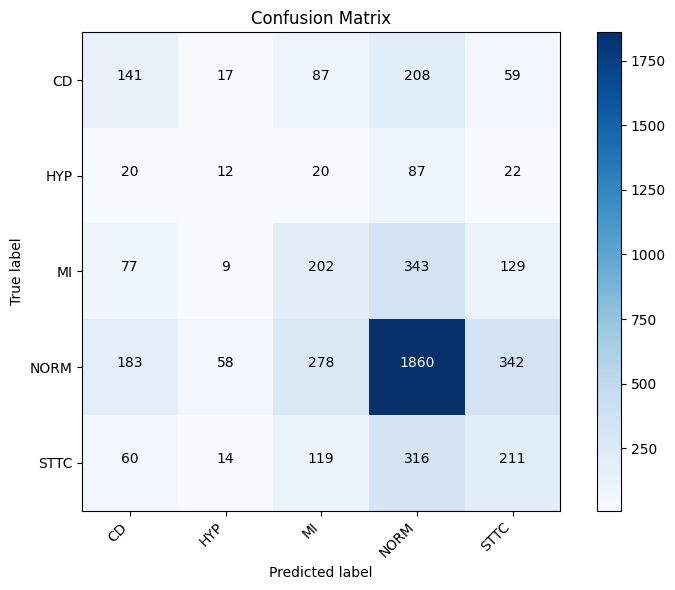

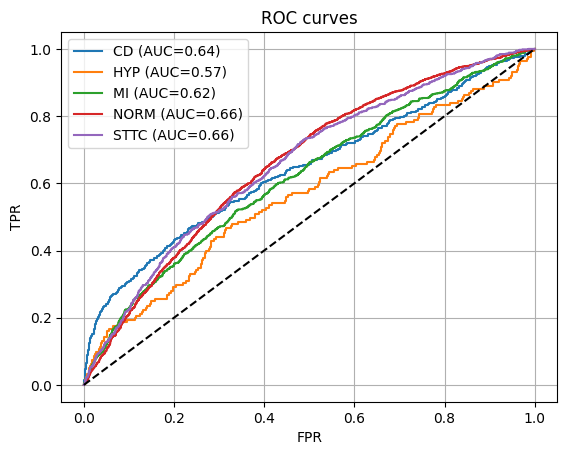

✅ Model saved as ecg_lstm_60_10_30.pt


In [5]:
# ==========================
# ECG LSTM: Full Training & Evaluation
# ==========================
import os
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_fscore_support, roc_curve, auc, roc_auc_score
)

from ptflops import get_model_complexity_info  # GFLOPs

# ==========================
# 1️⃣ Data Preparation
# ==========================
# Assuming X_filtered (numpy array) and Y_filtered['diagnostic_superclass'] (pd.Series) exist

# Split 60% train, 10% val, 30% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X_filtered, Y_filtered['diagnostic_superclass'],
    test_size=0.40,  # 40% for val+test
    random_state=42,
    stratify=Y_filtered['diagnostic_superclass']
)

# Split temp 1:3 → val 10%, test 30%
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.75,  # 0.75*40% = 30% test
    random_state=42,
    stratify=y_temp
)

print(f"✅ Data Split: Train {len(X_train)/len(X_filtered):.2%}, "
      f"Val {len(X_val)/len(X_filtered):.2%}, "
      f"Test {len(X_test)/len(X_filtered):.2%}")

# LSTM expects (batch, seq_len, features)
X_train_lstm = np.transpose(np.array(X_train), (0, 2, 1))
X_val_lstm   = np.transpose(np.array(X_val), (0, 2, 1))
X_test_lstm  = np.transpose(np.array(X_test), (0, 2, 1))

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

# Convert to tensors
X_train_tensor = torch.tensor(X_train_lstm, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_enc, dtype=torch.long)
X_val_tensor   = torch.tensor(X_val_lstm, dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val_enc, dtype=torch.long)
X_test_tensor  = torch.tensor(X_test_lstm, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test_enc, dtype=torch.long)

# Datasets & DataLoaders
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds   = TensorDataset(X_val_tensor, y_val_tensor)
test_ds  = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64)
test_loader  = DataLoader(test_ds, batch_size=64)

# ==========================
# 2️⃣ LSTM Model
# ==========================
class ECG_LSTM(nn.Module):
    def __init__(self, input_size=12, hidden_size=128, num_layers=2, n_classes=5, dropout=0.3):
        super(ECG_LSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden_size * 2, n_classes)  # bidirectional

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last timestep
        out = self.fc(out)
        return out

# ==========================
# 3️⃣ Training Setup
# ==========================
n_classes = len(le.classes_)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ECG_LSTM(input_size=X_train_tensor.shape[2], n_classes=n_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ==========================
# 4️⃣ GFLOPs estimation
# ==========================
try:
    # Input shape: (seq_len, input_size)
    macs, params = get_model_complexity_info(
        model, 
        (X_train_tensor.shape[1], X_train_tensor.shape[2]),
        as_strings=False,
        print_per_layer_stat=False
    )
    gflops = (macs * 2) / 1e9
    print(f"✅ Model Params: {params/1e6:.2f}M | GFLOPs per inference: {gflops:.3f}")
except Exception as e:
    print("⚠️ GFLOPs calculation skipped:", e)

# ==========================
# 5️⃣ Training Loop
# ==========================
EPOCHS = 50
train_losses, val_losses, val_accs = [], [], []

train_start_time = time.time()
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    correct, total = 0, 0
    val_loss = 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            logits = model(Xb)
            loss = criterion(logits, yb)
            val_loss += loss.item()
            predicted = torch.argmax(logits, dim=1)
            correct += (predicted == yb).sum().item()
            total += yb.size(0)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100.0 * correct / total
    val_losses.append(avg_val_loss)
    val_accs.append(val_accuracy)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")
train_end_time = time.time()
train_time = train_end_time - train_start_time
print(f"\nTraining completed in {train_time:.2f}s")

# ==========================
# 6️⃣ Test Evaluation
# ==========================
model.eval()
y_true, y_pred, y_prob = [], [], []

test_start_time = time.time()
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        logits = model(Xb)
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1)
        y_true.extend(yb.numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())
test_end_time = time.time()
test_time = test_end_time - test_start_time
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

print(f"\n✅ Test Accuracy: {(y_pred==y_true).mean()*100:.2f}%")
print(f"Test wall-clock time: {test_time:.2f}s ({test_time/len(y_true):.6f}s per sample)")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, le.classes_, rotation=45, ha='right')
plt.yticks(tick_marks, le.classes_)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment='center',
             color='white' if cm[i, j] > thresh else 'black')
plt.ylabel('True label'); plt.xlabel('Predicted label'); plt.tight_layout()
plt.show()

# ROC–AUC curves (one-vs-rest)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{le.classes_[i]} (AUC={roc_auc[i]:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC curves')
plt.legend(); plt.grid(True); plt.show()

# Save model
torch.save(model.state_dict(), "ecg_lstm_60_10_30.pt")
print("✅ Model saved as ecg_lstm_60_10_30.pt")


✅ Data Split: Train 60.00%, Val 10.00%, Test 30.00%
✅ Model Params: 3.80M | GFLOPs per inference: 0.327
Epoch 1/50 | Train Loss: 0.8095 | Val Loss: 0.6983 | Val Acc: 75.12%
Epoch 2/50 | Train Loss: 0.6531 | Val Loss: 0.7040 | Val Acc: 74.75%
Epoch 3/50 | Train Loss: 0.6153 | Val Loss: 0.6405 | Val Acc: 77.09%
Epoch 4/50 | Train Loss: 0.5815 | Val Loss: 0.6260 | Val Acc: 77.89%
Epoch 5/50 | Train Loss: 0.5536 | Val Loss: 0.6324 | Val Acc: 78.14%
Epoch 6/50 | Train Loss: 0.5244 | Val Loss: 0.6406 | Val Acc: 76.79%
Epoch 7/50 | Train Loss: 0.5095 | Val Loss: 0.7414 | Val Acc: 76.17%
Epoch 8/50 | Train Loss: 0.4943 | Val Loss: 0.6468 | Val Acc: 77.40%
Epoch 9/50 | Train Loss: 0.4641 | Val Loss: 0.6347 | Val Acc: 76.97%
Epoch 10/50 | Train Loss: 0.4250 | Val Loss: 0.6046 | Val Acc: 78.02%
Epoch 11/50 | Train Loss: 0.4021 | Val Loss: 0.6991 | Val Acc: 77.03%
Epoch 12/50 | Train Loss: 0.3651 | Val Loss: 0.6110 | Val Acc: 78.88%
Epoch 13/50 | Train Loss: 0.3263 | Val Loss: 0.7132 | Val Acc: 76

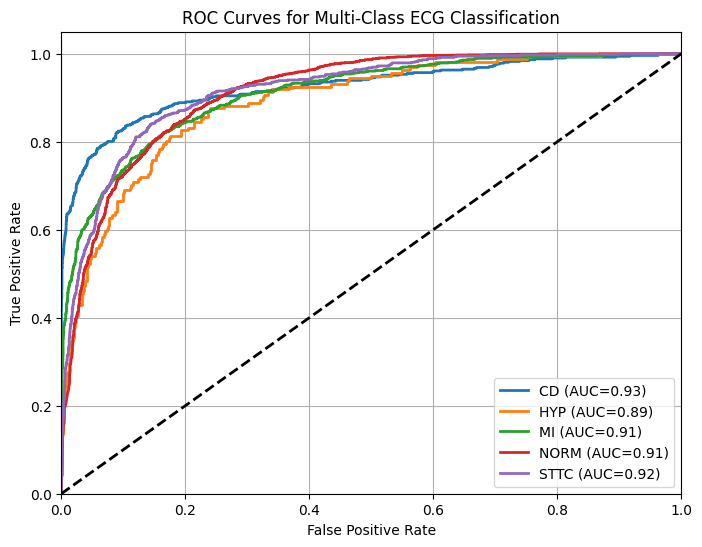

              precision    recall  f1-score   support

          CD       0.87      0.64      0.74       512
         HYP       0.43      0.31      0.36       161
          MI       0.68      0.65      0.66       760
        NORM       0.82      0.89      0.86      2721
        STTC       0.65      0.64      0.65       720

    accuracy                           0.77      4874
   macro avg       0.69      0.63      0.65      4874
weighted avg       0.77      0.77      0.77      4874



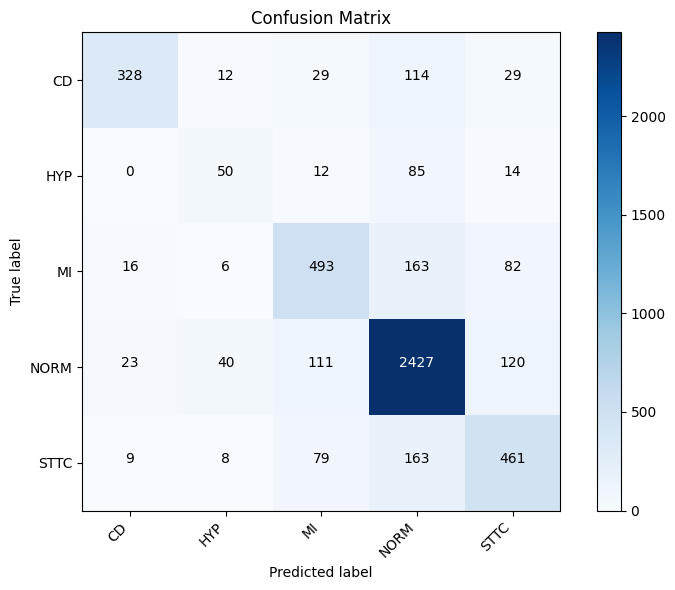

✅ Model saved as ecg_resnet1d.pt


In [6]:
# ==========================
# ECG ResNet-1D: Full Training & Evaluation
# ==========================
import os
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_fscore_support, roc_curve, auc, roc_auc_score
)

from ptflops import get_model_complexity_info

# ==========================
# 1️⃣ Data Preparation
# ==========================
# X_filtered: (n_samples, seq_len, n_leads)
# Y_filtered['diagnostic_superclass']

X_train, X_temp, y_train, y_temp = train_test_split(
    X_filtered, Y_filtered['diagnostic_superclass'],
    test_size=0.40,
    random_state=42,
    stratify=Y_filtered['diagnostic_superclass']
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.75,
    random_state=42,
    stratify=y_temp
)

print(f"✅ Data Split: Train {len(X_train)/len(X_filtered):.2%}, "
      f"Val {len(X_val)/len(X_filtered):.2%}, "
      f"Test {len(X_test)/len(X_filtered):.2%}")

# --- transpose to [batch, channels, seq_len] ---
X_train = np.transpose(X_train, (0, 2, 1))
X_val   = np.transpose(X_val, (0, 2, 1))
X_test  = np.transpose(X_test, (0, 2, 1))

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_enc, dtype=torch.long)
X_val_tensor   = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val_enc, dtype=torch.long)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test_enc, dtype=torch.long)

# DataLoaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64)
test_loader  = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64)

# ==========================
# 2️⃣ 1D ResNet Block
# ==========================
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=7, stride=stride, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=7, stride=1, padding=3, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

# ==========================
# 3️⃣ 1D ResNet Model
# ==========================
class ResNet1D(nn.Module):
    def __init__(self, n_classes, in_channels=12):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv1d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        )
        # Example: 3 residual blocks
        self.layer1 = ResidualBlock1D(64, 128, stride=2, downsample=nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm1d(128)
        ))
        self.layer2 = ResidualBlock1D(128, 256, stride=2, downsample=nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm1d(256)
        ))
        self.layer3 = ResidualBlock1D(256, 512, stride=2, downsample=nn.Sequential(
            nn.Conv1d(256, 512, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm1d(512)
        ))
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512, n_classes)

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

n_classes = len(le.classes_)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ResNet1D(n_classes=n_classes, in_channels=X_train_tensor.shape[1]).to(device)

# ==========================
# 4️⃣ GFLOPs estimation
# ==========================
macs, params = get_model_complexity_info(
    model, (X_train_tensor.shape[1], X_train_tensor.shape[2]),
    as_strings=False, print_per_layer_stat=False
)
gflops = (macs*2)/1e9
print(f"✅ Model Params: {params/1e6:.2f}M | GFLOPs per inference: {gflops:.3f}")

# ==========================
# 5️⃣ Training
# ==========================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
EPOCHS = 50
train_losses, val_losses, val_accs = [], [], []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    correct, total = 0, 0
    val_loss = 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            logits = model(Xb)
            loss = criterion(logits, yb)
            val_loss += loss.item()
            predicted = torch.argmax(logits, dim=1)
            correct += (predicted == yb).sum().item()
            total += yb.size(0)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100.0 * correct / total
    val_losses.append(avg_val_loss)
    val_accs.append(val_accuracy)
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

# ==========================
# 6️⃣ Test Evaluation
# ==========================
model.eval()
y_true, y_pred, y_prob = [], [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        logits = model(Xb)
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1)
        y_true.extend(yb.numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())
y_true, y_pred, y_prob = np.array(y_true), np.array(y_pred), np.array(y_prob)
print(f"\n✅ Test Accuracy: {(y_pred==y_true).mean()*100:.2f}%")
# ==========================
# 7️⃣ ROC–AUC Curves
# ==========================
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class ROC
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

fpr, tpr, roc_auc = {}, {}, {}
plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{le.classes_[i]} (AUC={roc_auc[i]:.2f})")

plt.plot([0,1], [0,1], 'k--', lw=2)  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Multi-Class ECG Classification")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, le.classes_, rotation=45, ha='right')
plt.yticks(tick_marks, le.classes_)
thresh = cm.max()/2.
for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i,format(cm[i,j],'d'), ha='center', color='white' if cm[i,j]>thresh else 'black')
plt.ylabel('True label'); plt.xlabel('Predicted label'); plt.tight_layout(); plt.show()

# Save model
torch.save(model.state_dict(), "ecg_resnet1d.pt")
print("✅ Model saved as ecg_resnet1d.pt")


✅ Data Split: Train 60.00%, Val 10.00%, Test 30.00%
✅ Model Params: 0.14M | GFLOPs per inference: 0.271
Epoch 1/50 | Train Loss: 1.2618 | Val Loss: 1.2421 | Val Acc: 55.85%
Epoch 2/50 | Train Loss: 1.2462 | Val Loss: 1.2407 | Val Acc: 56.34%
Epoch 3/50 | Train Loss: 1.2570 | Val Loss: 1.2697 | Val Acc: 55.48%
Epoch 4/50 | Train Loss: 1.2630 | Val Loss: 1.2495 | Val Acc: 55.91%
Epoch 5/50 | Train Loss: 1.2579 | Val Loss: 1.2476 | Val Acc: 56.10%
Epoch 6/50 | Train Loss: 1.2497 | Val Loss: 1.2438 | Val Acc: 55.91%
Epoch 7/50 | Train Loss: 1.2473 | Val Loss: 1.2482 | Val Acc: 55.97%
Epoch 8/50 | Train Loss: 1.2485 | Val Loss: 1.2435 | Val Acc: 56.03%
Epoch 9/50 | Train Loss: 1.2458 | Val Loss: 1.2394 | Val Acc: 56.10%
Epoch 10/50 | Train Loss: 1.2428 | Val Loss: 1.2365 | Val Acc: 55.97%
Epoch 11/50 | Train Loss: 1.2443 | Val Loss: 1.2394 | Val Acc: 56.03%
Epoch 12/50 | Train Loss: 1.2435 | Val Loss: 1.2373 | Val Acc: 56.22%
Epoch 13/50 | Train Loss: 1.2416 | Val Loss: 1.2312 | Val Acc: 56

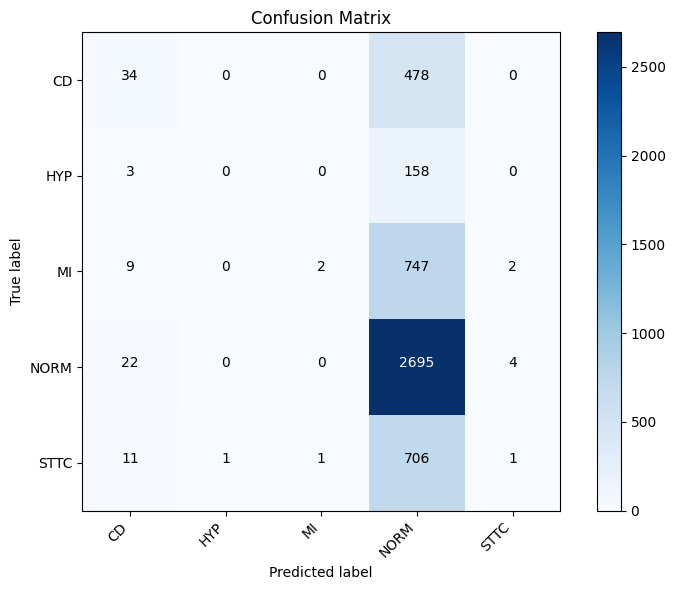

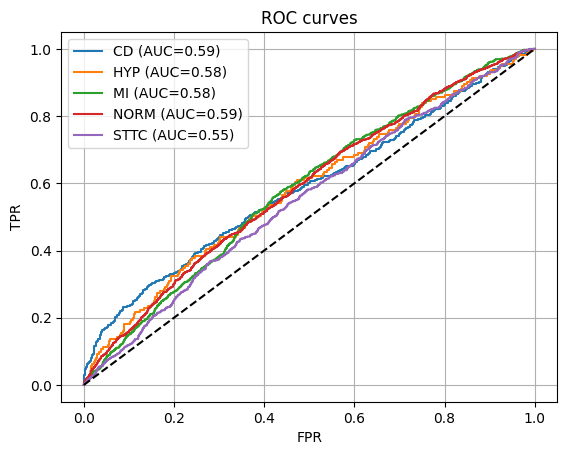

✅ Model saved as ecg_rnn_60_10_30.pt


In [7]:
# ==========================
# ECG RNN: Full Training & Evaluation
# ==========================
import os
import time
import itertools
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc
)

from ptflops import get_model_complexity_info

# ==========================
# 1️⃣ Data Preparation
# ==========================
# X_filtered: (n_samples, seq_len, n_leads)
# Y_filtered['diagnostic_superclass']: pd.Series

# Split 60% train, 10% val, 30% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X_filtered, Y_filtered['diagnostic_superclass'],
    test_size=0.40,
    random_state=42,
    stratify=Y_filtered['diagnostic_superclass']
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.75,
    random_state=42,
    stratify=y_temp
)

print(f"✅ Data Split: Train {len(X_train)/len(X_filtered):.2%}, "
      f"Val {len(X_val)/len(X_filtered):.2%}, "
      f"Test {len(X_test)/len(X_filtered):.2%}")

# RNN expects (batch, seq_len, features)
X_train_rnn = np.array(X_train)
X_val_rnn   = np.array(X_val)
X_test_rnn  = np.array(X_test)

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

# Convert to tensors
X_train_tensor = torch.tensor(X_train_rnn, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_enc, dtype=torch.long)
X_val_tensor   = torch.tensor(X_val_rnn, dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val_enc, dtype=torch.long)
X_test_tensor  = torch.tensor(X_test_rnn, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test_enc, dtype=torch.long)

# DataLoaders
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds   = TensorDataset(X_val_tensor, y_val_tensor)
test_ds  = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64)
test_loader  = DataLoader(test_ds, batch_size=64)

# ==========================
# 2️⃣ RNN Model
# ==========================
class ECG_RNN(nn.Module):
    def __init__(self, input_size=12, hidden_size=128, num_layers=2, n_classes=5, dropout=0.3):
        super(ECG_RNN, self).__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            nonlinearity='tanh',
            dropout=dropout,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden_size * 2, n_classes)  # bidirectional

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # last timestep
        out = self.fc(out)
        return out

n_classes = len(le.classes_)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ECG_RNN(input_size=X_train_tensor.shape[2], n_classes=n_classes).to(device)

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ==========================
# 3️⃣ GFLOPs estimation
# ==========================
try:
    macs, params = get_model_complexity_info(
        model,
        (X_train_tensor.shape[1], X_train_tensor.shape[2]),  # (seq_len, features)
        as_strings=False,
        print_per_layer_stat=False
    )
    gflops = (macs * 2) / 1e9
    print(f"✅ Model Params: {params/1e6:.2f}M | GFLOPs per inference: {gflops:.3f}")
except Exception as e:
    print("⚠️ GFLOPs calculation skipped:", e)

# ==========================
# 4️⃣ Training Loop
# ==========================
EPOCHS = 50
train_losses, val_losses, val_accs = [], [], []

train_start_time = time.time()
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    correct, total = 0, 0
    val_loss = 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            logits = model(Xb)
            loss = criterion(logits, yb)
            val_loss += loss.item()
            predicted = torch.argmax(logits, dim=1)
            correct += (predicted == yb).sum().item()
            total += yb.size(0)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100.0 * correct / total
    val_losses.append(avg_val_loss)
    val_accs.append(val_accuracy)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")
train_end_time = time.time()
train_time = train_end_time - train_start_time
print(f"\nTraining completed in {train_time:.2f}s")

# ==========================
# 5️⃣ Test Evaluation
# ==========================
model.eval()
y_true, y_pred, y_prob = [], [], []

test_start_time = time.time()
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        logits = model(Xb)
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1)
        y_true.extend(yb.numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())
test_end_time = time.time()
test_time = test_end_time - test_start_time
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

print(f"\n✅ Test Accuracy: {(y_pred==y_true).mean()*100:.2f}%")
print(f"Test wall-clock time: {test_time:.2f}s ({test_time/len(y_true):.6f}s per sample)")

# Classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, le.classes_, rotation=45, ha='right')
plt.yticks(tick_marks, le.classes_)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment='center',
             color='white' if cm[i, j] > thresh else 'black')
plt.ylabel('True label'); plt.xlabel('Predicted label'); plt.tight_layout()
plt.show()

# ROC–AUC curves
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{le.classes_[i]} (AUC={roc_auc[i]:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC curves')
plt.legend(); plt.grid(True); plt.show()

# Save model
torch.save(model.state_dict(), "ecg_rnn_60_10_30.pt")
print("✅ Model saved as ecg_rnn_60_10_30.pt")
